### import libraries

In [30]:
using QuantumOptics, PyPlot, PyCall, JLD

### define parameters for the position and momentum basis

In [4]:
#coupling factor
g=-26

#momentum
m=1 

#position and momentum basis in x
x_min= -20
x_max = 20
x_steps = 64
dx = (x_max - x_min) / x_steps
b_x = PositionBasis(x_min, x_max, x_steps)
b_px = MomentumBasis(b_x)
xsample = samplepoints(b_x)

#position and momentum basis in y
y_min= -10
y_max = 10
y_steps = 32
dy = (y_max - y_min) / y_steps
b_y = PositionBasis(y_min, y_max, y_steps)
b_py = MomentumBasis(b_y)
ysample = samplepoints(b_y)

#momentum:
px = momentum(b_px)
py = momentum(b_py)

#TransformationOperator for composite bases:
b_comp_x = tensor(b_x, b_y)
b_comp_p = tensor(b_px, b_py)
Txp = transform(b_comp_x, b_comp_p)
Tpx = transform(b_comp_p, b_comp_x)

#Hamiltonians:
Hkinx = LazyTensor(b_comp_p, [1, 2], [px^2/2, one(b_py)])
Hkiny = LazyTensor(b_comp_p, [1, 2], [one(b_px), py^2/2])

Hkinx_FFT = LazyProduct(Txp, Hkinx, Tpx)
Hkiny_FFT = LazyProduct(Txp, Hkiny, Tpx)

Hpsi = diagonaloperator(b_comp_x, Ket(b_comp_x).data) # proportional zu |psi|^2
H0 = LazySum(Hkinx_FFT, Hkiny_FFT, Hpsi)

LazySum(dim=2048x2048)
  basis: [Position(xmin=-20.0, xmax=20.0, N=64) ⊗ Position(xmin=-10.0, xmax=10.0, N=32)]
  operators: 3

In [29]:
function H(t, psi) #function updating state dependent term in H
	Hpsi.data.nzval .= g/dx*abs2.(psi.data)
	return H0
end

H (generic function with 1 method)

### parameters for two gaussian wavepacket

In [ ]:
#position
x0 = 5
y0 = 0

#momentum
p0_x = 2
p0_y = 0

#size
sigmax = 2
sigmay= 1

#first wavepacket
psix1 = gaussianstate(b_x, -x0, p0_x, sigmax)
psiy1 = gaussianstate(b_y, y0, p0_y, sigmay)
psi1 = psix1 ⊗ psiy1

#second wavepacket
psix2 = gaussianstate(b_x, x0, -p0_x, sigmax)
psiy2 = gaussianstate(b_y, y0, p0_y, sigmay)
psi2 = psix2 ⊗ psiy2

psi = normalize(psi1 + psi2)

### defining time-scale

In [ ]:
T = [0:0.1:10;]
tout, psit = timeevolution.schroedinger_dynamic(T, psi, H)
density = [reshape(abs2.(psi.data), (x_steps, y_steps))' for psi=psit]

### Plotting the results

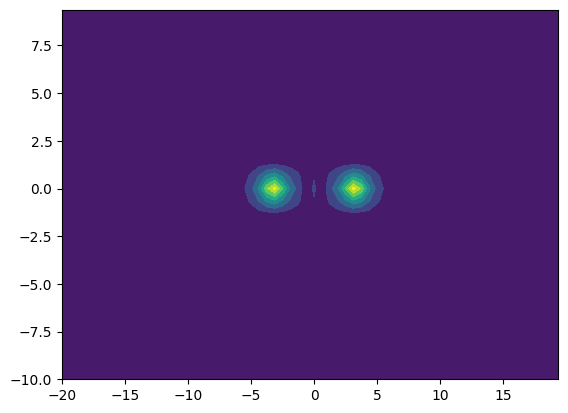

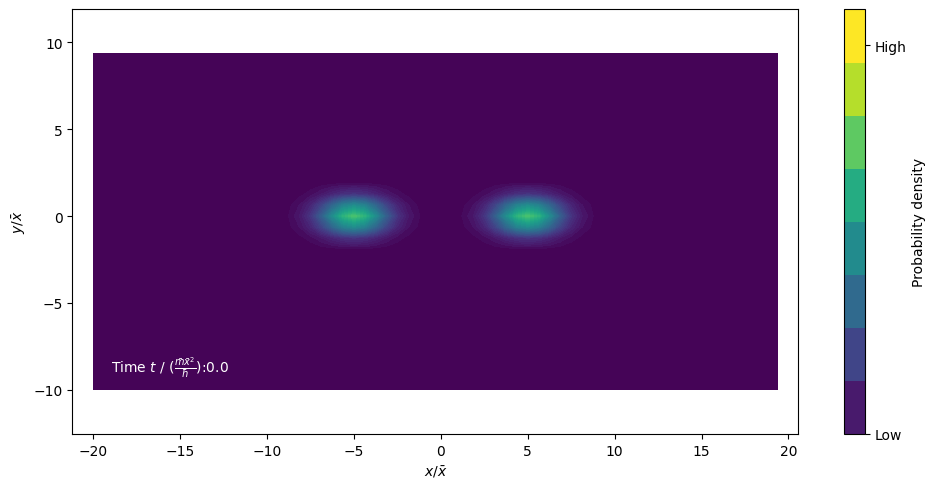

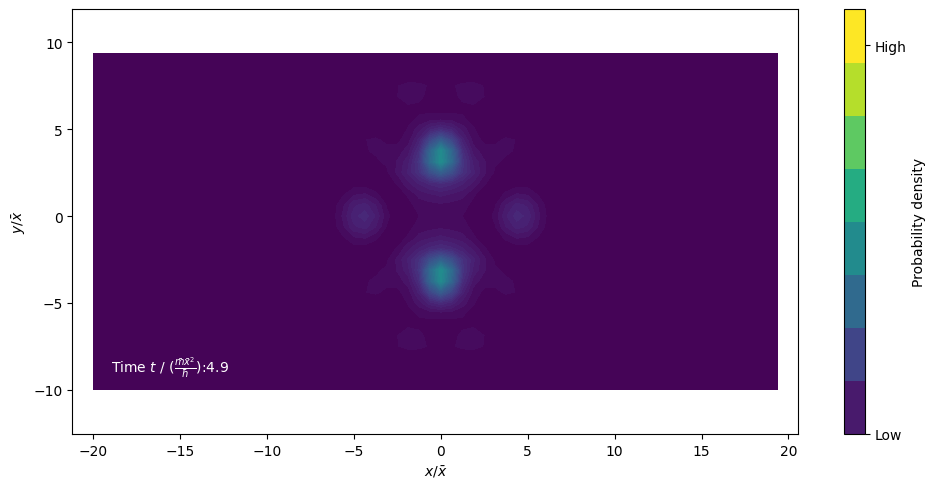

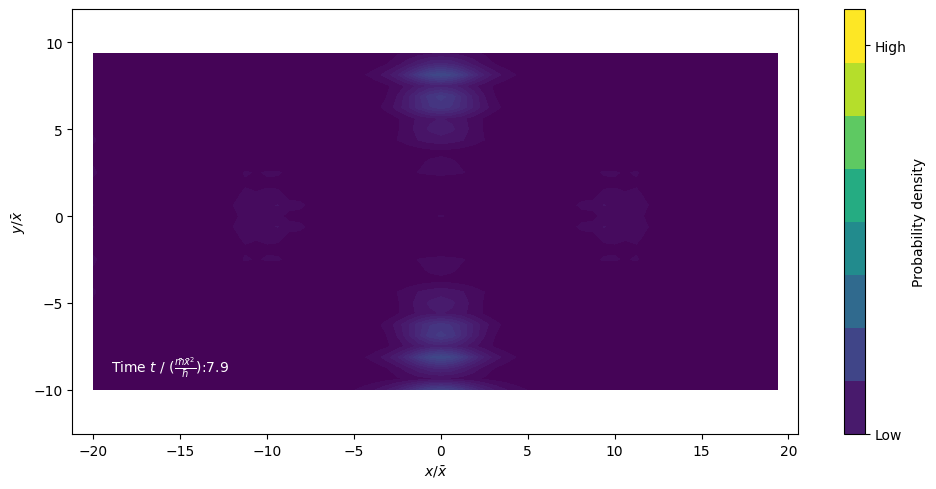

0.043920142339112886


In [31]:
#Daten für Plot:
max = maximum(density[10])
textx = minimum(xsample)+1
texty = minimum(ysample)+1
c1 = contourf(xsample, ysample, density[10], vmax=max )
println(max)

#plots for different times:
for i = [1,50,80]
	a = figure(figsize=(10,5))
	b = axis("equal")
	clev = LinRange(0,max,50)
	c = contourf(xsample, ysample, density[i], clev)
	cbar = colorbar(c1, ticks=[0, max])
	cbar.set_label("Probability density")
	cbar.set_ticklabels(["Low", "High"])
	xlabel(L"$x / \bar{x}$")
	ylabel(L"$y / \bar{x}$")
	text(textx, texty, L"Time $t$ / $(\frac{\bar{m}\bar{x}^2}{\hbar})$:"*"$(T[i])", color="white")
	tight_layout()

end
#end